# WTB

Automatic classification of birds for this project : http://www.cabane-oiseaux.org/

## Data cooking
First, prepare the data : we need a train dataset and a validation dataset.
We use the Keras ImageDataGenerator that can build a training set from directories containing images.
Each sub directory must contains a category of bird : Keras will associate each one to a category in the model.

In [9]:
IMG_ROWS = 224
IMG_COLS = 224
EPOCHS = 10
BATCH_SIZE = 32
DIR_TRAIN = '/home/kvjw3322/Developement/WTB/photos/photos_train'
DIR_VALID = '/home/kvjw3322/Developement/WTB/photos/photos_valid'
DIR_TEST = '/home/kvjw3322/Developement/WTB/photos/photos_test'

In [98]:
import PIL
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras import applications
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

# Generator for train
train_image_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)
train_iterator = train_image_generator.flow_from_directory(
    DIR_TRAIN, # Root directory
    target_size=(IMG_ROWS, IMG_COLS), # Images will be processed to this size
    batch_size=BATCH_SIZE, # How many images are processed at the same time ?
    class_mode='categorical') # Each subdir is a category

# Generator for validation
valid_image_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)
valid_iterator = valid_image_generator.flow_from_directory(
    DIR_VALID,
    target_size=(IMG_ROWS, IMG_COLS), # Images will be processed to this size
    batch_size=BATCH_SIZE, # How many images are processed at the same time ?
    class_mode='categorical')

# Generator for test
test_image_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input)
test_iterator = test_image_generator.flow_from_directory(
    DIR_TEST,
    target_size=(IMG_ROWS, IMG_COLS), # Images will be processed to this size
    batch_size=BATCH_SIZE, # How many images are processed at the same time ?
    class_mode='categorical',
    shuffle=False)

# Number of classes
NUM_OF_CLASSES = len(train_iterator.class_indices)

Found 7526 images belonging to 7 classes.
Found 2164 images belonging to 7 classes.
Found 1084 images belonging to 7 classes.


In [99]:
NUM_OF_TRAIN_SAMPLES = train_iterator.samples
NUM_OF_VALID_SAMPLES = valid_iterator.samples
NUM_OF_TEST_SAMPLES = test_iterator.samples

In [100]:
# This Keras Callbak saves the best model according to the accuracy metric
filepath="../models/bestmodel-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Fine Tuning

> Note : network that relies on a pre-trained model, VGG16.


In [101]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_ROWS, IMG_COLS, 3))

In [102]:
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD

model_ft_top = Sequential()
model_ft_top.add(Flatten())
model_ft_top.add(Dense(1024, activation="relu"))
model_ft_top.add(Dropout(0.5))
model_ft_top.add(Dense(NUM_OF_CLASSES, activation="softmax"))

# The model must have weight initialized (compile ? load weight ?)
# model_ft.load_weights()

model_ft = Model(input=base_model.input, output=model_ft_top(base_model.output))

# Freeze the 16th first layers
for layer in model_ft.layers[:15]:
    layer.trainable = False

model_ft.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

/home/kvjw3322/.virtualenvs/p3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [16]:
model_ft.fit_generator(generator=train_iterator, 
                    steps_per_epoch=NUM_OF_TRAIN_SAMPLES // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_iterator,
                    validation_steps=NUM_OF_VALID_SAMPLES // BATCH_SIZE,
                    callbacks=[checkpoint])
                    

Epoch 1/10
235/235 [==============================] - 2201s 9s/step - loss: 1.2472 - acc: 0.8182 - val_loss: 0.2680 - val_acc: 0.9230

Epoch 00001: val_acc improved from -inf to 0.92304, saving model to ../models/bestmodel-01-0.92.hdf5
Epoch 2/10
235/235 [==============================] - 2176s 9s/step - loss: 0.1390 - acc: 0.9557 - val_loss: 0.2341 - val_acc: 0.9451

Epoch 00002: val_acc improved from 0.92304 to 0.94512, saving model to ../models/bestmodel-02-0.95.hdf5
Epoch 3/10
235/235 [==============================] - 2178s 9s/step - loss: 0.0579 - acc: 0.9824 - val_loss: 0.1913 - val_acc: 0.9536

Epoch 00003: val_acc improved from 0.94512 to 0.95356, saving model to ../models/bestmodel-03-0.95.hdf5
Epoch 4/10
235/235 [==============================] - 2179s 9s/step - loss: 0.0331 - acc: 0.9888 - val_loss: 0.2510 - val_acc: 0.9522

Epoch 00004: val_acc did not improve from 0.95356
Epoch 5/10
235/235 [==============================] - 2176s 9s/step - loss: 0.0198 - acc: 0.9943 - va

In [26]:
# model_loaded = keras.models.load_model("/home/kvjw3322/Developement/WTB/models/10-0.94.hdf5")

## Confusion Matrix
Let's valid our model and search for weakness ! The confusion matrix displays in a table the result of all the predictions : each column represents a given category for prediction, each row represents a given category for expected result. The data shown in the matrix diagonal are the correct predictions. Any other cell is a confusion between two classes.

In [103]:
# Compute prediction for all test samples
Y_pred = model_ft.predict_generator(test_iterator, NUM_OF_TEST_SAMPLES // BATCH_SIZE+1)

# For each prediction, get the "best" class
y_pred = np.argmax(Y_pred, axis=1)

In [124]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

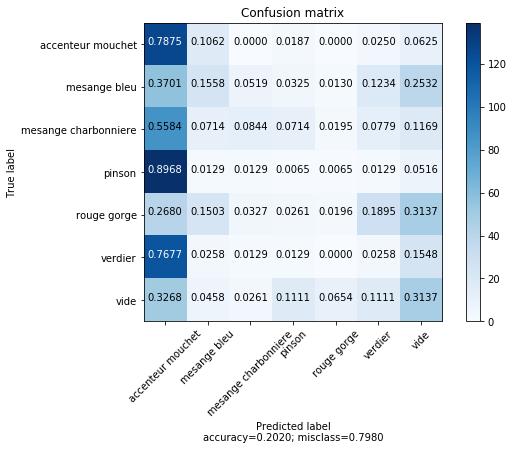

In [129]:
from sklearn.metrics import confusion_matrix 

plot_confusion_matrix(confusion_matrix(test_iterator.classes, y_pred),
                          list(test_iterator.class_indices.keys()))

## Classification report

In [131]:
from sklearn.metrics import classification_report

print(classification_report(test_iterator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.79      0.32       160
           1       0.27      0.16      0.20       154
           2       0.38      0.08      0.14       154
           3       0.02      0.01      0.01       155
           4       0.16      0.02      0.03       153
           5       0.05      0.03      0.03       155
           6       0.25      0.31      0.28       153

   micro avg       0.20      0.20      0.20      1084
   macro avg       0.19      0.20      0.14      1084
weighted avg       0.19      0.20      0.15      1084



## Manual validation

In [77]:
from random import randint
from keras.preprocessing.image import DirectoryIterator
def get_random_image(image_iterator: DirectoryIterator) -> (str, str, int, dict):
    picture_path = image_iterator.filenames[randint(0, len(image_iterator.filenames)-1)]
    category = os.path.dirname(picture_path)
    mapper = { v:k for k,v in image_iterator.class_indices.items()}

    return os.path.join(image_iterator.directory, picture_path), category,  mapper

get_random_image(test_iterator)

('/home/kvjw3322/Developement/WTB/photos/photos_test/rouge gorge/02-20180122_151820-00.jpg',
 'rouge gorge',
 {0: 'accenteur mouchet',
  1: 'mesange bleu',
  2: 'mesange charbonniere',
  3: 'pinson',
  4: 'rouge gorge',
  5: 'verdier',
  6: 'vide'})

In [93]:
def predict(picture_path:str, mapper:dict):
    picture = PIL.Image.open(picture_path)
    picture = picture.resize(size=(224,224))
    picture_array = img_to_array(img=picture)
    picture_array = np.expand_dims(picture_array, axis=0)
    return mapper.get(np.argmax(model_ft.predict(picture_array), axis=1)[0])

accenteur mouchet ? That was a verdier


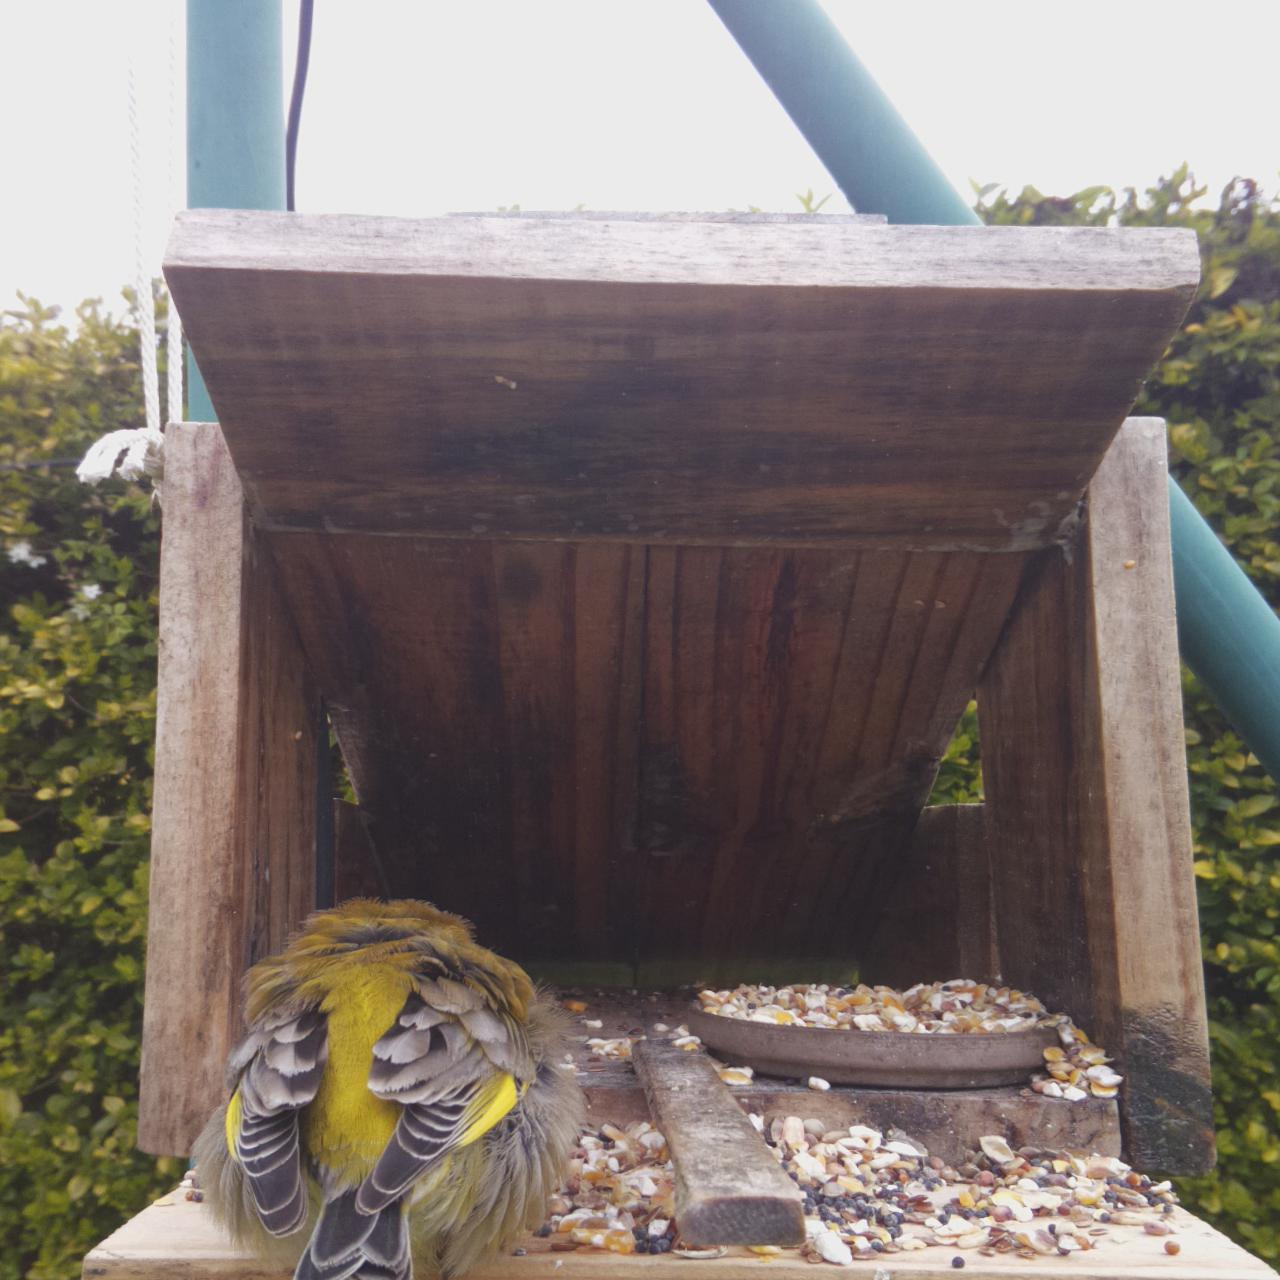

In [137]:
picture_path, category, mapper = get_random_image(test_iterator)
print(f"{predict(picture_path, mapper)} ? That was a {category}")

import IPython.display
IPython.display.display(IPython.display.Image(picture_path, width=200))

## RNN : layer by layer

> note : network built from scratch, without any pre-trained layer

We build the RNN, adding layers one by one

- Conv2D : The input_shape is 150,150 to match the images size. The last dimension is '3' because each pixel is represented by 3 values (RGB). For grayscale images, this parameter would have been '1' (one value to store the grey level). We choose to use 32 filters (or feature maps) : all the filters are appyed to the source image at the same time. The convolution layer "learn" the values of each filter (as synaptic coefficients are in a Dense hidden layer). The kernel_size is the matrix size of the filter
- MaxPooling2D : The subsampling layer get the best value (max with maxpooling) of a set of x pixels. This set comes from a sub matrix of "pool_size"

In [13]:
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Model, Sequential

model = Sequential() 
model.add(Conv2D(filters=32, input_shape=(IMG_ROWS, IMG_COLS, 3), kernel_size=(5,5)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

# Transform the output matrix into a vector for the Dense layer
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(NUM_OF_CLASSES, activation="softmax"))

## Let's learn !
It's time to make our network learn : we compile it (as Keras ask us to), and run the learning from our data.

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(generator=train_iterator, 
                    steps_per_epoch=NUM_OF_TRAIN_SAMPLES // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_iterator,
                    validation_steps=NUM_OF_TEST_SAMPLES // BATCH_SIZE,
                    callbacks=[checkpoint])

# Model unit validation
Let's get a model prediction from a given picture

In [14]:
# Load model from disk
model.load_weights("/home/kvjw3322/Documents/Prez/WTB/data/bestmodel-25-0.55.hdf5")

In [15]:
picture_path = '/home/kvjw3322/Documents/Prez/WTB/images/train/mesange bleu/01-20160116_092159-00.jpg'
#picture_path = '/home/kvjw3322/Documents/Prez/WTB/images/rouge gorge/01-20160116_094045-00.jpg'

picture = Image.open(picture_path)
picture = picture.resize(size=(150,150))
picture_array = img_to_array(img=picture)
picture_array = np.expand_dims(picture_array, axis=0)
get_human_prediction(model, picture_array)

'rouge gorge'

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

In [71]:
# Y_pred = model.predict_generator(valid_iterator, NUM_OF_TEST_SAMPLES // BATCH_SIZE+1)
# y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(valid_iterator.classes, y_pred))
# print('Classification Report')
# target_names = train_iterator.class_indices.keys()
# print(classification_report(valid_iterator.classes, y_pred, target_names=target_names))